In [1]:
%matplotlib inline

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import os
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import genpareto
from osgeo import gdal

In [6]:
def extract_max_rows_no_duplicates(folder_path):

    # Create an empty DataFrame to store results
    result_df = pd.DataFrame(columns=['File_Name', 'Date', 'Max_Size_1', 'Max_Size_2'])

    # Get a list of all CSV files matching the pattern
    csv_files = [file for file in os.listdir(folder_path) if file.startswith('a') and file.endswith('.csv') and file[-5].isdigit()]

    # Iterate through each CSV file
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        #print(f"Processing file: {file}")
        
        try:
            # Read the CSV file into a pandas DataFrame
            df = pd.read_csv(file_path)
            
            # Check if 'size_1' column exists in the DataFrame
            if 'size_1' not in df.columns:
                print(f"Skipping file '{file}' as it does not contain a 'size_1' column.")
                continue
            
            columns_to_keep = ["date", "size_1", "size_2"]
            df = df[columns_to_keep]

            max_size_1_indices = df['size_1'].idxmax()
            max_size_2_indices = df['size_2'].idxmax()
            
            max_size_1_rows = df.loc[max_size_1_indices]
            max_size_2_rows = df.loc[max_size_2_indices]

            # Append the iceberg information to df
            for i in range(len(max_size_1_rows)-1):
                result_df = result_df._append({'File_Name': file,
                                       'Date': max_size_1_rows.iloc[0],
                                        'Max_Size_1': max_size_1_rows.iloc[1],
                                        'Max_Size_2': max_size_1_rows.iloc[2]}, ignore_index=True)
        except KeyError:
            print(f"Skipping file '{file}' as it does not contain a 'size_1' column.")

    # Drop rows with identical values of Max_Size_1 and Max_Size_2 for each date
    result_df.drop_duplicates(subset=['Date', 'Max_Size_1', 'Max_Size_2'], inplace=True)
    
    # Save the result DataFrame to a CSV file
    result_file_path = os.path.join(folder_path, 'quadrentA.csv')
    result_df.to_csv(result_file_path, index=False)
    print(f"Results saved to: {result_file_path}")
    
    # Return the result DataFrame
    return result_df

In [7]:
folder_path = "BYU_consolidated_database/"
result_df_dup = extract_max_rows_no_duplicates(folder_path)
print(result_df_dup)

Results saved to: BYU_consolidated_database/quadrentA.csv
    File_Name     Date Max_Size_1 Max_Size_2
0     a32.csv  1995057         41         21
2     a14.csv  1980349         30         20
4     a50.csv  2003096         10          1
6     a05.csv  1979301         15         10
8     a41.csv  1999031         13          8
..        ...      ...        ...        ...
146   a40.csv  1999031         19          6
148   a04.csv  1979294         30         10
150   a22.csv  1986271         45         43
152   a13.csv  1980223         30         10
154   a31.csv  1991090         20          9

[77 rows x 4 columns]


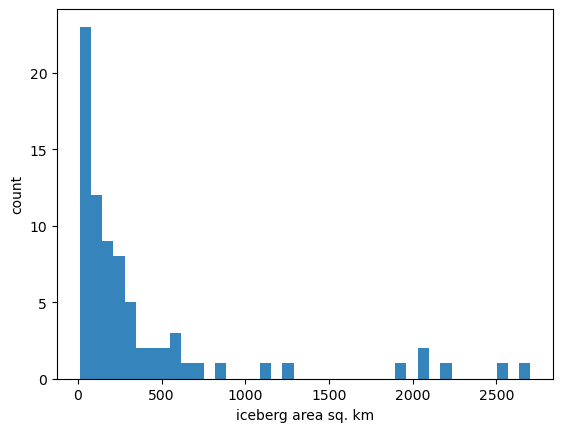

In [19]:
plt.hist(result_df_dup.Max_Size_1 * result_df_dup.Max_Size_2, bins=40, alpha = 0.9);
plt.xlabel('iceberg area sq. km'); plt.ylabel('count');

In [28]:
result_df_dup['Area'] = (result_df_dup['Max_Size_1'] * 1.852) * (result_df_dup['Max_Size_2'] * 1.852)
result_df_dup.to_csv('quadrentA_largest.csv', index=False)

In [29]:
def find_largest_area_by_year(result_df):
    if result_df.empty:
        print("DataFrame is empty.")
        return None

    # Convert Date to datetime and extract YEAR
    result_df['Date'] = pd.to_datetime(result_df['Date'], format='%Y%j', errors='coerce')
    result_df['Year'] = result_df['Date'].dt.year

    # Drop rows with no values
    result_df.dropna(subset=['Date'], inplace=True)

    # Group by Year and find the row with the largest value of Area
    largest_areas_by_year = result_df.groupby('Year').apply(lambda x: x.loc[x['Area'].idxmax()])
    return largest_areas_by_year


/tmp/ipykernel_237/1904948248.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  largest_areas_by_year = result_df.groupby('Year').apply(lambda x: x.loc[x['Area'].idxmax()])


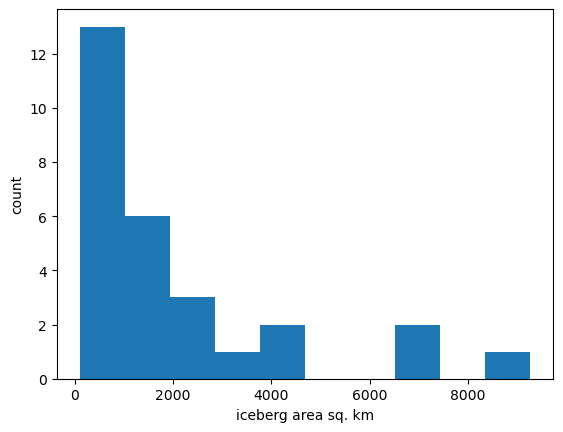

In [30]:
largest_areas_by_year = find_largest_area_by_year(result_df_dup)
#print(largest_areas_by_year)
plt.hist(largest_areas_by_year.Area);
plt.xlabel('iceberg area sq. km'); plt.ylabel('count');

In [31]:
largest_areas_by_year.to_csv('largest_annual_iceberg_quadrentA.csv', index=False)

In [32]:
largest_areas_by_year

,File_Name,Date,Max_Size_1,Max_Size_2,Area,Year
Year,,,,,,
1978,a01.csv,1978-10-22,45,25,3858.642000,1978
1979,a04.csv,1979-10-21,30,10,1028.971200,1979
1980,a14.csv,1980-12-14,30,20,2057.942400,1980
1981,a16.csv,1981-11-15,35,15,1800.699600,1981
1983,a17.csv,1983-04-17,25,23,1972.194800,1983
1986,a20.csv,1986-01-26,52,52,9274.460416,1986
1987,a26.csv,1987-10-04,16,8,439.027712,1987
1989,a28.csv,1989-09-24,22,10,754.578880,1989
1991,a31.csv,1991-03-31,20,9,617.382720,1991
